In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive


/home/fausto/Documentos/facultad/Inteligencia Computacional/hospital-bed-prediction/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Modelos estadisticos ARIMA y SARIMA
---

In [2]:
df = pd.read_csv('./data/daily_hospitalized_patients.csv', parse_dates=['date'])
df = df.sort_values('date')
# --- Ajustar formato del DataFrame ---
df = df.rename(columns={
    'date': 'ds',
    'num_patients': 'y'
})
horizon = 7
df['unique_id'] = 'PACIENTES'
df.head()

,ds,y,unique_id
0,2017-04-01,30,PACIENTES
1,2017-04-02,45,PACIENTES
2,2017-04-03,65,PACIENTES
3,2017-04-04,78,PACIENTES
4,2017-04-05,71,PACIENTES


In [6]:
test = df.groupby("unique_id").tail(horizon)
train = df.drop(test.index).reset_index(drop=True)

unique_ids = ['PACIENTES']

small_train = train[train['unique_id'].isin(unique_ids)]
small_test = test[test['unique_id'].isin(unique_ids)]
 
models = [
  AutoARIMA(seasonal=False, alias="ARIMA"), 
  AutoARIMA(season_length=7 , alias="SARIMA")
]

sf = StatsForecast(models=models, freq='D')
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)


eval_df = pd.merge(test, arima_preds, on=['unique_id', 'ds'], how='inner')

# Calculamos métricas (MAE, etc.)
arima_eval = evaluate(
    eval_df,
    metrics=[mae],
)

print("\n📈 Evaluación del modelo ARIMA/SARIMA:")
print(arima_eval)

print("\n🔮 Predicciones:")
print(arima_preds.tail(7))


📈 Evaluación del modelo ARIMA/SARIMA:
   unique_id metric  ARIMA     SARIMA
0  PACIENTES    mae   14.0  16.478333

🔮 Predicciones:
   unique_id         ds  ARIMA      SARIMA
0  PACIENTES 2019-03-23  177.0  175.652557
1  PACIENTES 2019-03-24  177.0  177.673721
2  PACIENTES 2019-03-25  177.0  179.021164
3  PACIENTES 2019-03-26  177.0  182.558197
4  PACIENTES 2019-03-27  177.0  180.873901
5  PACIENTES 2019-03-28  177.0  179.526459
6  PACIENTES 2019-03-29  177.0  181.042328


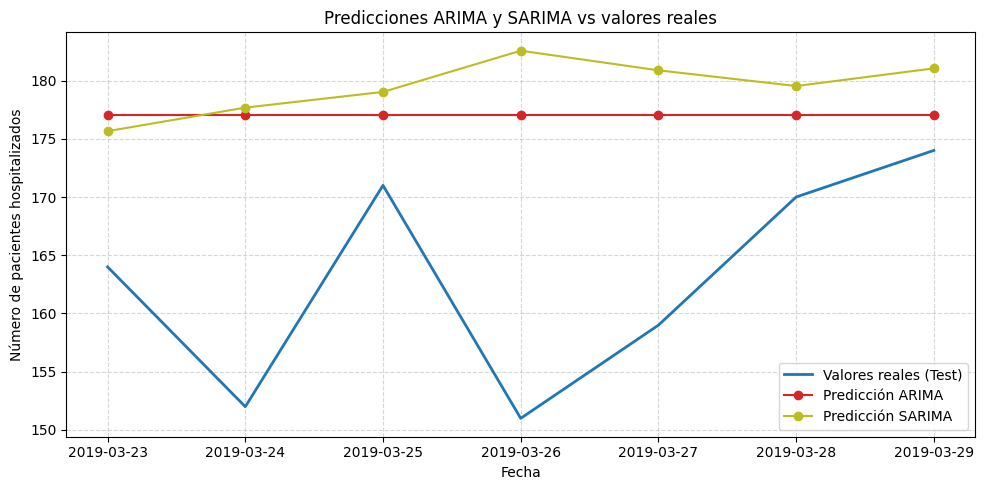

In [15]:
plt.figure(figsize=(10,5))
plt.plot(small_test['ds'], small_test['y'], label='Valores reales (Test)', color='#1f77b4', linewidth=2)
plt.plot(eval_df['ds'], eval_df['ARIMA'], label='Predicción ARIMA', color='#d62728', marker='o')
plt.plot(eval_df['ds'], eval_df['SARIMA'], label='Predicción SARIMA', color='#bcbd22', marker='o')
plt.title('Predicciones ARIMA y SARIMA vs valores reales')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes hospitalizados')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Aplicamos validacion cruzada

In [16]:
small_df = df[df['unique_id'].isin(unique_ids)]
models = [
  AutoARIMA(seasonal=False, alias="ARIMA"),
  AutoARIMA(season_length=horizon, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D") # frecuencia = daily
cv_df = sf.cross_validation(
  h = horizon, 
  df=small_df, 
  n_windows=8, # Cantidad de ventanas que toma. Ej primera ventana [1 a 900] y predice 901 a 907, segunda ventana [1 a 907] y predice 908 a 914, etc.
  step_size=horizon, 
  refit=True # Reajusta el modelo en cada ventana
  )

cv_df.head()

,unique_id,ds,cutoff,y,ARIMA,SARIMA
0,PACIENTES,2019-02-02,2019-02-01,226.0,202.0,200.876999
1,PACIENTES,2019-02-03,2019-02-01,189.0,202.0,198.133072
2,PACIENTES,2019-02-04,2019-02-01,229.0,202.0,199.962357
3,PACIENTES,2019-02-05,2019-02-01,244.0,202.0,200.145294
4,PACIENTES,2019-02-06,2019-02-01,240.0,202.0,201.608719


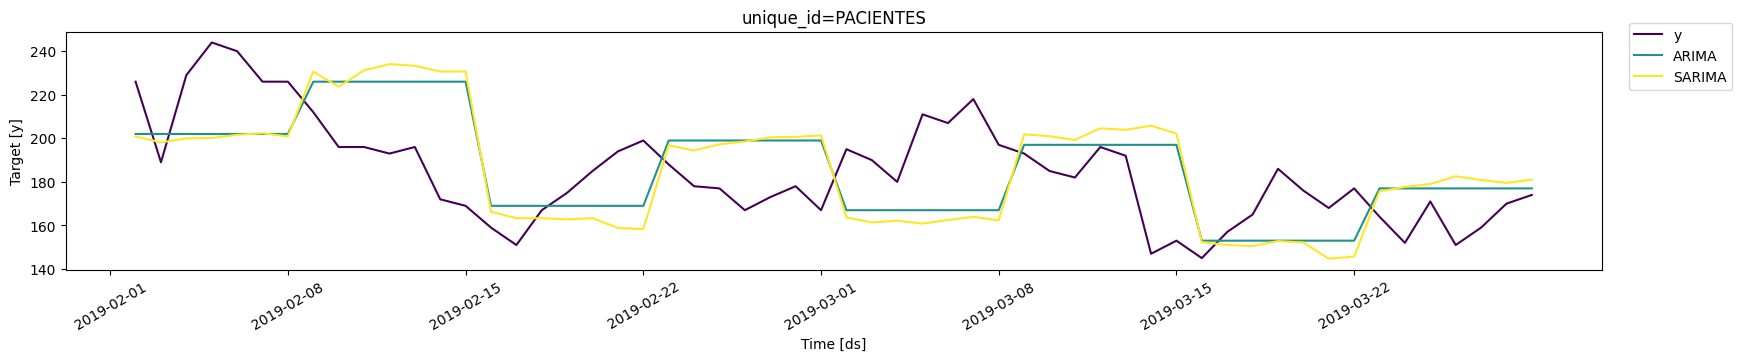

In [17]:
plot_series(
  df = df, 
  forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),
  ids=["PACIENTES"],
  max_insample_length=56,
  palette="viridis"
)